In [1]:
import librosa as li
import os
from glob import glob
import json
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch.nn as nn

In [7]:
device = torch.device('cuda')

In [8]:
top_path = "/data/atiam_ml_mvae/nsynth-train"
files = glob(f'{os.path.abspath(top_path)}/**/*.wav', recursive=True)
filenames = [os.path.basename(f).removesuffix('.wav') for f in files]
with open(os.path.join(top_path, 'examples.json')) as f:
    meta = json.load(f)

In [10]:
class func2module(nn.Module):
    def __init__(self,f):
        super(func2module,self).__init__()
        self.f = f
    def forward(self,x):
        return self.f(x)

In [15]:
import torchaudio.transforms as T
import torch.nn as nn
nfft = 1024
transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000,hop_length= nfft//4,n_mels=128,n_fft=nfft,norm='slaney'),
).to(device)
inverse_transform = nn.Sequential(
    T.InverseMelScale(sample_rate=16000,n_mels=128,n_stft=nfft // 2 + 1,norm="slaney"),
    T.GriffinLim(n_fft=nfft, hop_length=nfft//4),
).to(device)

In [23]:
def getitem(idx: int, load_audio = True) -> tuple[torch.Tensor, float, str]:
    fname = files[idx]
    _fname = filenames[idx]
    if load_audio:
        (2**15)/16000
        audio, _ = li.load(fname, sr=16000, mono=True, duration=2.0)
        audio = torch.from_numpy(audio).to(device)
        x = transform(audio)
    else: 
        x = None
        audio = None
    pitch = meta[_fname]['pitch']
    return {"x": x, "pitch": pitch, "fname": _fname, "audio" : audio}

In [26]:
*_, n_sample = spec.shape
n_pad = 2 ** (n_sample - 1).bit_length() - n_sample
n_pad

2

torch.Size([128, 128])


torch.Size([32000]) torch.Size([32512])


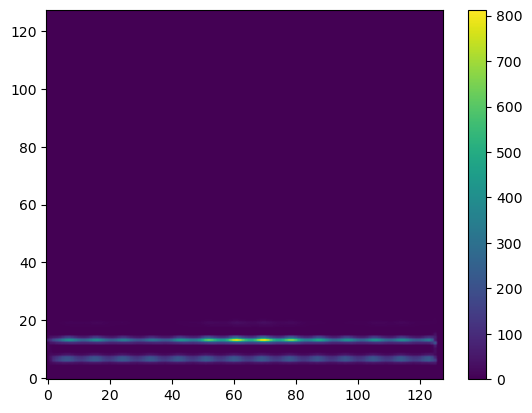

In [28]:
found = 0
for i in range(0):
    item = getitem(i,load_audio=False)
    if item['fname'] == 'bass_synthetic_134-022-100':
        found = i
        print(found)
        break
item = getitem(found)
spec, pitch, fname, audio = item['x'],item['pitch'],item['fname'],item['audio']
spec = nn.functional.pad(spec, (0, 2))
recreated_audio = inverse_transform(spec)
print(spec.shape)
display(Audio(audio.cpu(),rate=16000))
display(Audio(recreated_audio.cpu(),rate=16000))
print(audio.shape, recreated_audio.shape)
plt.imshow(spec.cpu(),origin="lower",aspect='auto')
plt.colorbar()
plt.show()

In [34]:
print(spec.shape)
enc1=nn.Conv1d(in_channels=128,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(spec)
print(enc1.shape)
enc2=nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(enc1)
print(enc2.shape)
enc3=nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1,device=device)(enc2)
print(enc3.shape)


torch.Size([128, 128])
torch.Size([512, 64])
torch.Size([512, 32])
torch.Size([512, 16])


In [36]:
print(enc3.shape)
dec1 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0, device=device)(enc3)
print(dec1.shape)
dec2 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0,device=device)(enc2)
print(dec2.shape)
dec3 = nn.ConvTranspose1d(in_channels=512,out_channels=512,kernel_size=4,stride=2,padding=1,output_padding=0,device=device)(enc1)
print(dec3.shape)
nn.Conv1d(512,512,kernel_size=3,padding='same',device=device)(dec3).shape

torch.Size([512, 16])
torch.Size([512, 32])
torch.Size([512, 64])
torch.Size([512, 128])


torch.Size([512, 128])

In [10]:
import numpy as np

In [11]:
a=torch.Tensor([[1,2,3],[6,4,5]])
a/a.max(axis=1,keepdims=True).values

tensor([[0.3333, 0.6667, 1.0000],
        [1.0000, 0.6667, 0.8333]])

In [50]:
from PIL import Image
from torchvision import transforms as vT
img = Image.open("individualImage.png")
img = vT.ToTensor()(img)[0]
plt.imshow(img,aspect='auto',origin='lower')
plt.colorbar()
plt.show()
img = img.to(device)
created_spectro = T.InverseMelScale(sample_rate=16000,n_mels=128,n_stft=1024 // 2 + 1,norm="slaney").to(device)(img)
created_audio=li.griffinlim(created_spectro.cpu().numpy(),n_fft=1024,hop_length=1024//4)
plt.plot(created_audio)
plt.show()
display(Audio(created_audio,rate=16000))


r_audio = inverse_transform(img).cpu()

display(Audio(r_audio,rate=16000))


FileNotFoundError: [Errno 2] No such file or directory: 'individualImage.png'

In [114]:
from datetime import datetime
def find_most_recent_VAE():
    found_files = []
    for _, _, files in os.walk("results"):
        for file in files:
            if len(file)>4 and file[:4] == "VAE_":
                strdate = file[4:]
                date_object = datetime.strptime(strdate,"%d-%m-%Y_%H_%M")
                found_files.append(date_object)
    if found_files:
        found_date = (sorted(found_files)[-1]).strftime("%d-%m-%Y_%H_%M")
        most_recent_file = "VAE_"+found_date
        return most_recent_file
    else:
        raise Exception("No model found")

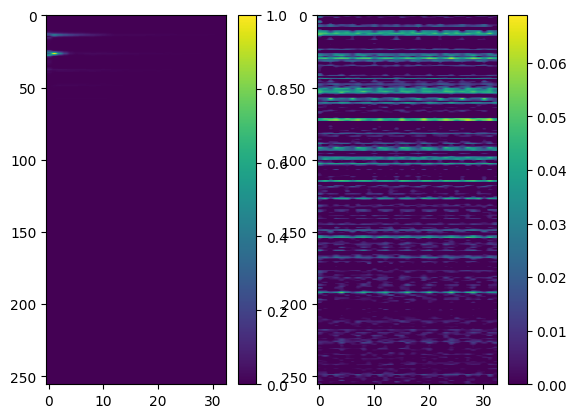

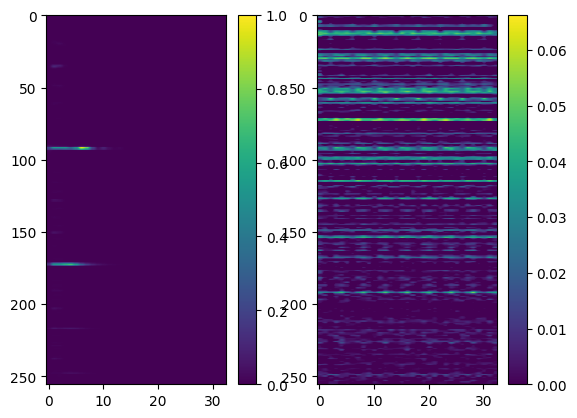

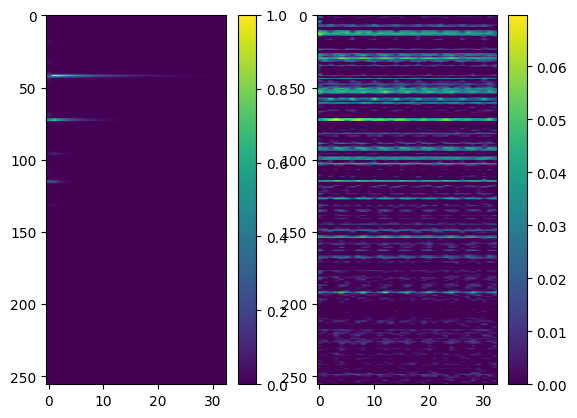

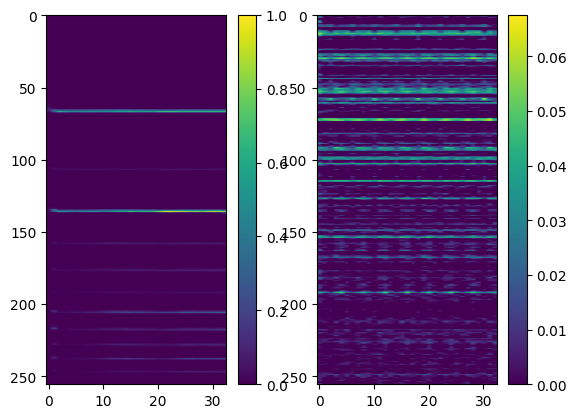

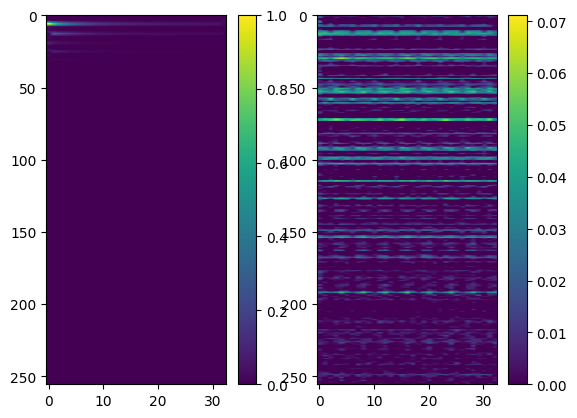

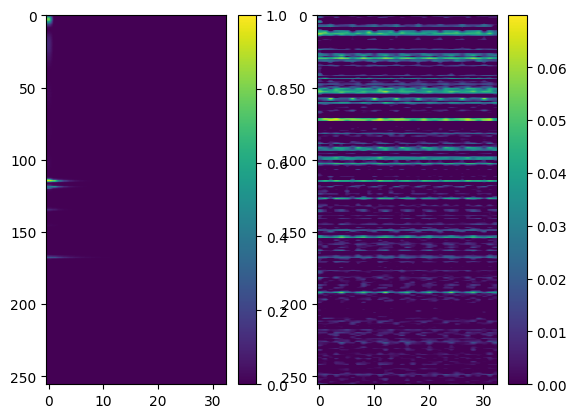

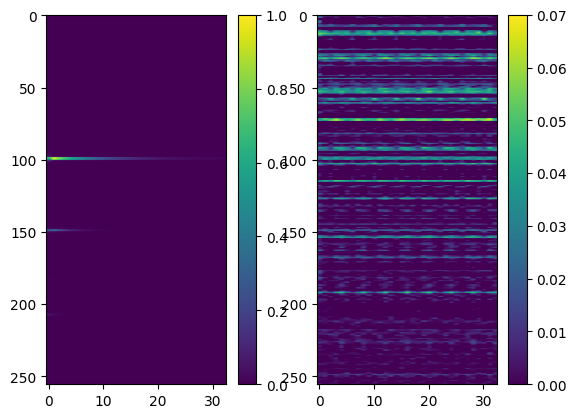

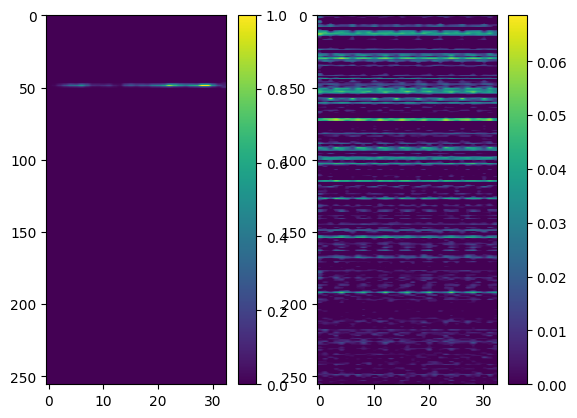

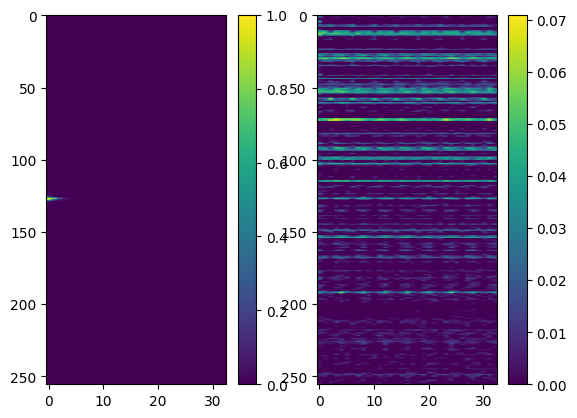

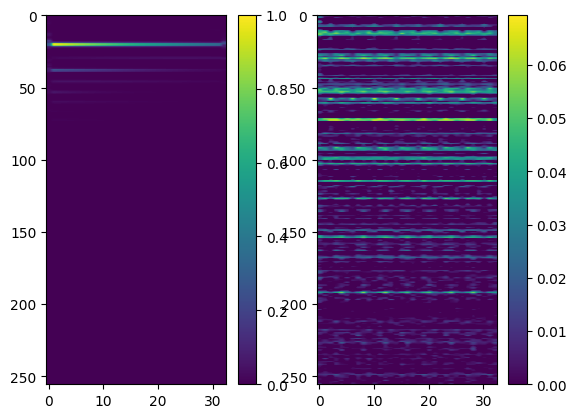

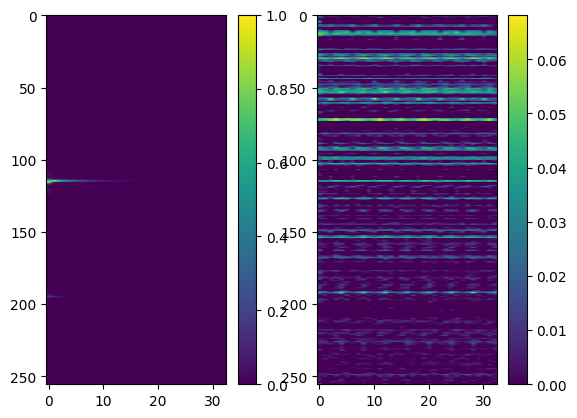

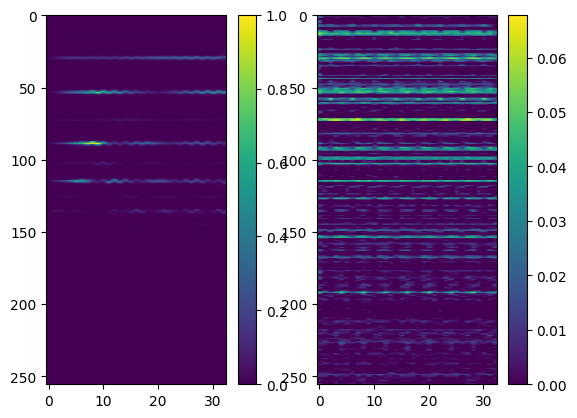

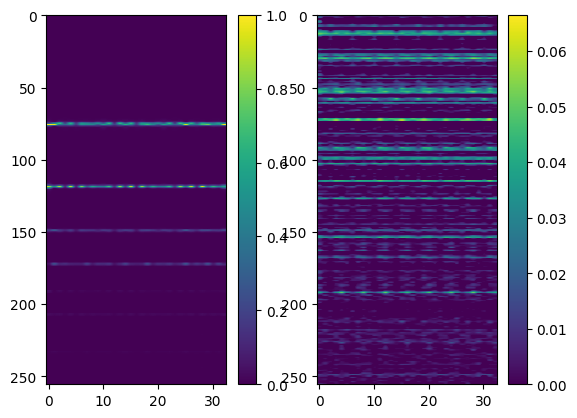

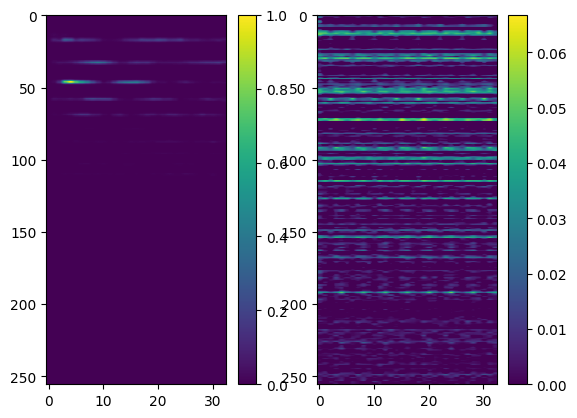

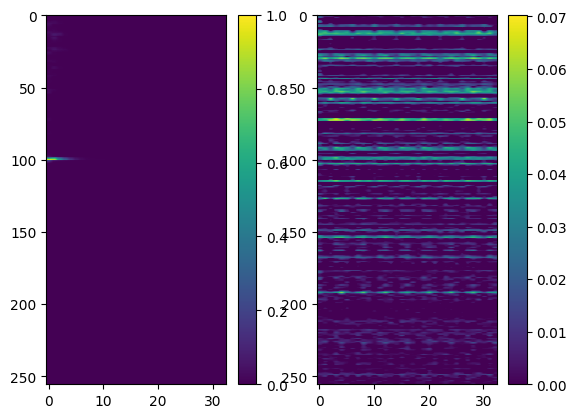

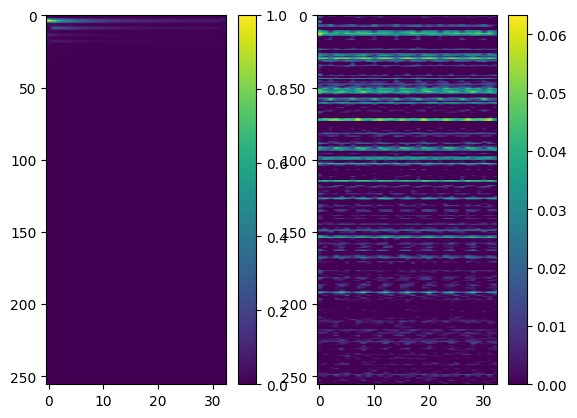

In [122]:
original = torch.load('original_spec_tensor')
generated = torch.load('generated_spec_tensor')
for i in range(16):
    plt.subplot(121)
    plt.imshow(original.cpu()[i],aspect='auto')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(generated.cpu()[i],aspect='auto',vmin=0)
    plt.colorbar()
    plt.show()


In [120]:
model = torch.load('results/'+find_most_recent_VAE())
with torch.no_grad():
    generated = model(spec[None,:,:])[0]
    plt.imshow(generated.cpu(),cmap="gray")
    plt.colorbar()
    plt.show()
    plt.imshow(spec.cpu(),cmap="gray")
    plt.colorbar()
    plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x160 and 640x256)